# Bayesian Estimation of Differential Equations

Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters. Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [26]:
using Turing, Distributions, DataFrames, DifferentialEquations, DiffEqSensitivity

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

# Disable Turing's progress meter for this tutorial.
Turing.turnprogress(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/aamzallag/.julia/packages/Turing/j5VJb/src/Turing.jl:22


false

## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$\frac{dx}{dt} = (\alpha - \beta y)x$
 
$\frac{dy}{dt} = (\delta x - \gamma)y$


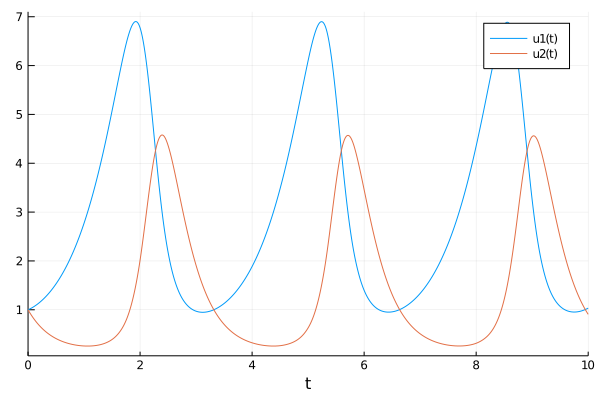

In [27]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, γ, δ  = p
  du[1] = (α - β*y)x # dx =
  du[2] = (δ*x - γ)y # dy = 
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob,Tsit5())
plot(sol)

We'll generate the data to use for the parameter estimation from simulation. 
With the `saveat` [argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units. To make the data look more realistic, we add random noise using the function `randn`.

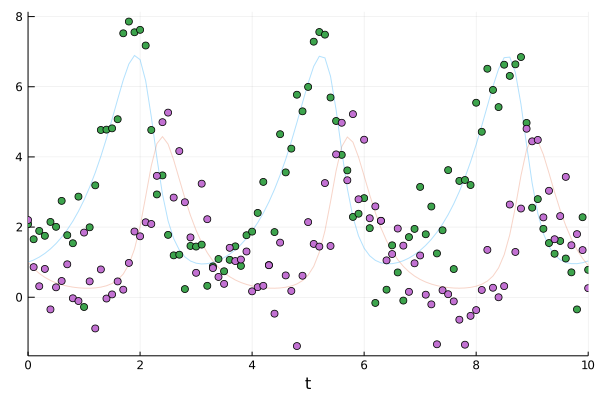

In [28]:
sol1 = solve(prob,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

## Direct Handling of Bayesian Estimation with Turing

Previously, functions in Turing and DifferentialEquations were not inter-composable, so Bayesian inference of differential equations needed to be handled by another package called [DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) (note that DiffEqBayes works also with CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl - see the [DiffEqBayes docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for more info).

From now on however, Turing and DifferentialEquations are completely composable and we can write of the differential equation inside a Turing `@model` and it will just work. Therefore, we can rewrite the Lotka Volterra parameter estimation problem with a Turing `@model` interface as below:

In [29]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata)

# This next command runs 3 independent chains without using multithreading. 
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/Adva

Chains MCMC chain (500×17×3 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 500
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           α    1.5557    0.0527     0.0014    0.0028   353.0656    1.0030  
           β    1.0915    0.0537     0.0014    0.0027   429.2588    1.0006  
           γ    2.8793    0.1400     0.0036    0.0071   357.5663    1.0032  
           δ    0.9390    0.0500     0.0013    0.0025   358.8500    1.0034  
           σ    0.8132    0.0417     0.0011    0.0019  

The estimated parameters are close to the desired parameter values. We can also check that the chains have converged in the plot.

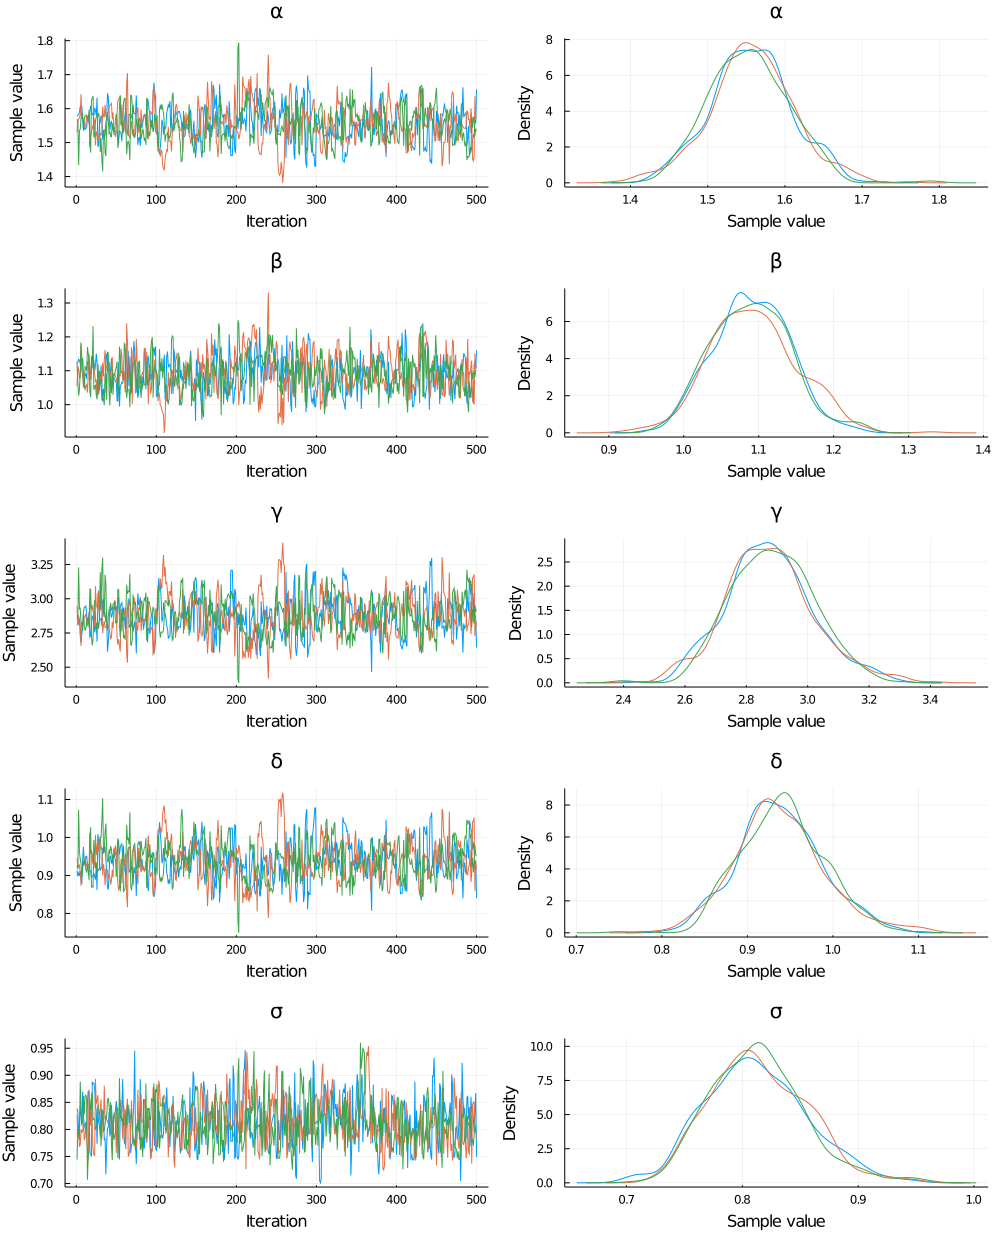

In [30]:
plot(chain)

### Data retrodiction 
In Bayesian analysis it is often useful to retrodict the data, i.e. generate simulated data using samples from the posterior distribution, and compare to the original data (see for instance section 3.3.2 - model checking of McElreath's book "Statistical Rethinking"). Here, we solve again the ODE using the output in `chain`, for 300 randomly picked posterior samples. We plot this ensemble of solutions to check if the solution resembles the data. 

In [31]:
pl = scatter(sol1.t, odedata');

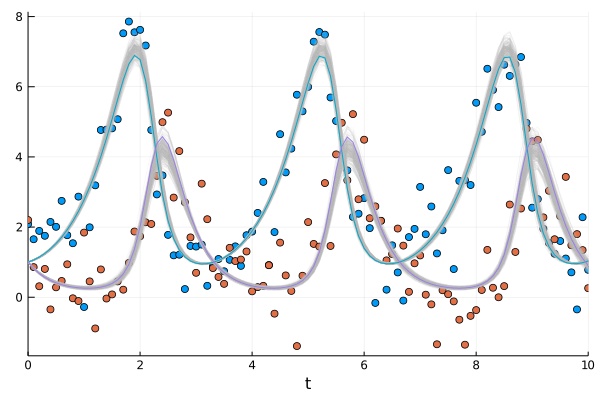

In [32]:
for k in sample(1:size(chain.value, 1), 300) 
    resol = solve(remake(prob,p=chain.value[k, [13, 14, 15, 16], 2].data),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
#display(pl)
plot!(sol1, w=1, legend = false)

In the plot above, the 300 retrodicted time courses from the posterior are plotted in gray, and the original data are the blue and red dots, and the solution that was used to generate the data are the green and purple lines. We can see that, even though we added quite a bit of noise to the data (see dot plot above), the posterior distribution reproduces quite accurately the "true" ODE solution.

## Inference of Delay Differential Equations

Here we show an example of inference with another type of differential equation: a Delay Differential Equation (DDE). A DDE is an DE system where derivatives are function of values at an earlier point in time. This is useful to model a delayed effect, like incubation time of a virus for instance. 

For this, we will define [a `DDEProblem`, from the package DifferentialEquations.jl](https://diffeq.sciml.ai/stable/tutorials/dde_example/). 

Here is a delayed version of the lokta voltera system:

$\frac{dx}{dt} = \alpha x(t-\tau) - \beta y(t) x(t)$
 
$\frac{dy}{dt} = - \gamma y(t) + \delta x(t) y(t) $

Where $x(t-\tau)$ is the variable $x$ at an earlier time point. We specify the delayed variable with a function `h(p, t)`, as described in the [DDE example](https://diffeq.sciml.ai/stable/tutorials/dde_example/).

In [12]:
Threads.nthreads()

4

In [43]:
function delay_lotka_volterra(du,u,h,p,t)
    x, y = u
    α,β,γ,δ = p
    du[1] = α*h(p,t-1)[1] - β*x*y
    du[2] = -γ*y + δ*x*y
end

p = (1.5,1.0,3.0,1.0); u0 = [1.0;1.0]
tspan = (0.0,10.0)
_h(p,t) = ones(2)
prob1 = DDEProblem(delay_lotka_volterra,u0,_h,tspan,p)

DDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

In [44]:
sol = solve(prob1,saveat=0.1)
#plot(sol)
ddedata = Array(sol)
ddedata = ddedata + 0.5 * randn(size(ddedata))

2×101 Array{Float64,2}:
 0.650378  -0.000964806  0.764218  …  2.92568  2.64278  2.68791  2.70634
 1.35768    0.670298     0.689187     1.63094  1.81623  1.65266  1.59456

Plot the data:

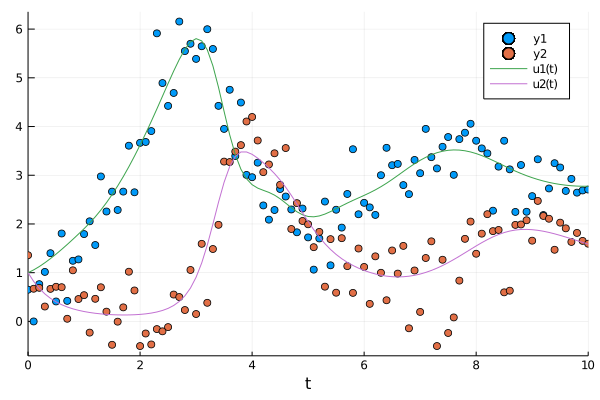

In [45]:
scatter(sol.t, ddedata'); plot!(sol)

Now we define and run the Turing model. 

In [15]:
Turing.setadbackend(:forwarddiff)
@model function fitlv(data)
    
    σ ~ InverseGamma(2, 3)
    α ~ Truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ Truncated(Normal(1.2,0.5),0,2)
    γ ~ Truncated(Normal(3.0,0.5),1,4)
    δ ~ Truncated(Normal(1.0,0.5),0,2)
    
    p = [α,β,γ,δ]
    
    #prob = DDEProblem(delay_lotka_volterra,u0,_h,tspan,p)
    prob = remake(prob1, p=p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(ddedata)

DynamicPPL.Model{var"###evaluator#677",(:data, :T),Tuple{Array{Float64,2},Type{Array{Float64,1}}},(),DynamicPPL.ModelGen{var"###generator#678",(:data, :T),(:T,),Tuple{Type{Array{Float64,1}}}}}(##evaluator#677, NamedTuple{(:data, :T),Tuple{Array{Float64,2},Type{Array{Float64,1}}}}(([1.304015520964287 0.8965101935456398 … 2.9838241896635265 3.62964214354095; 0.6004836456456475 0.7534388988307814 … 1.2355901181593267 2.054865369953125], Array{Float64,1})), DynamicPPL.ModelGen{var"###generator#678",(:data, :T),(:T,),Tuple{Type{Array{Float64,1}}}}(##generator#678, NamedTuple{(:T,),Tuple{Type{Array{Float64,1}}}}((Array{Float64,1},))))

Then we draw samples using multithreading; this time, we draw 3 independent chains in parallel.

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/Adva

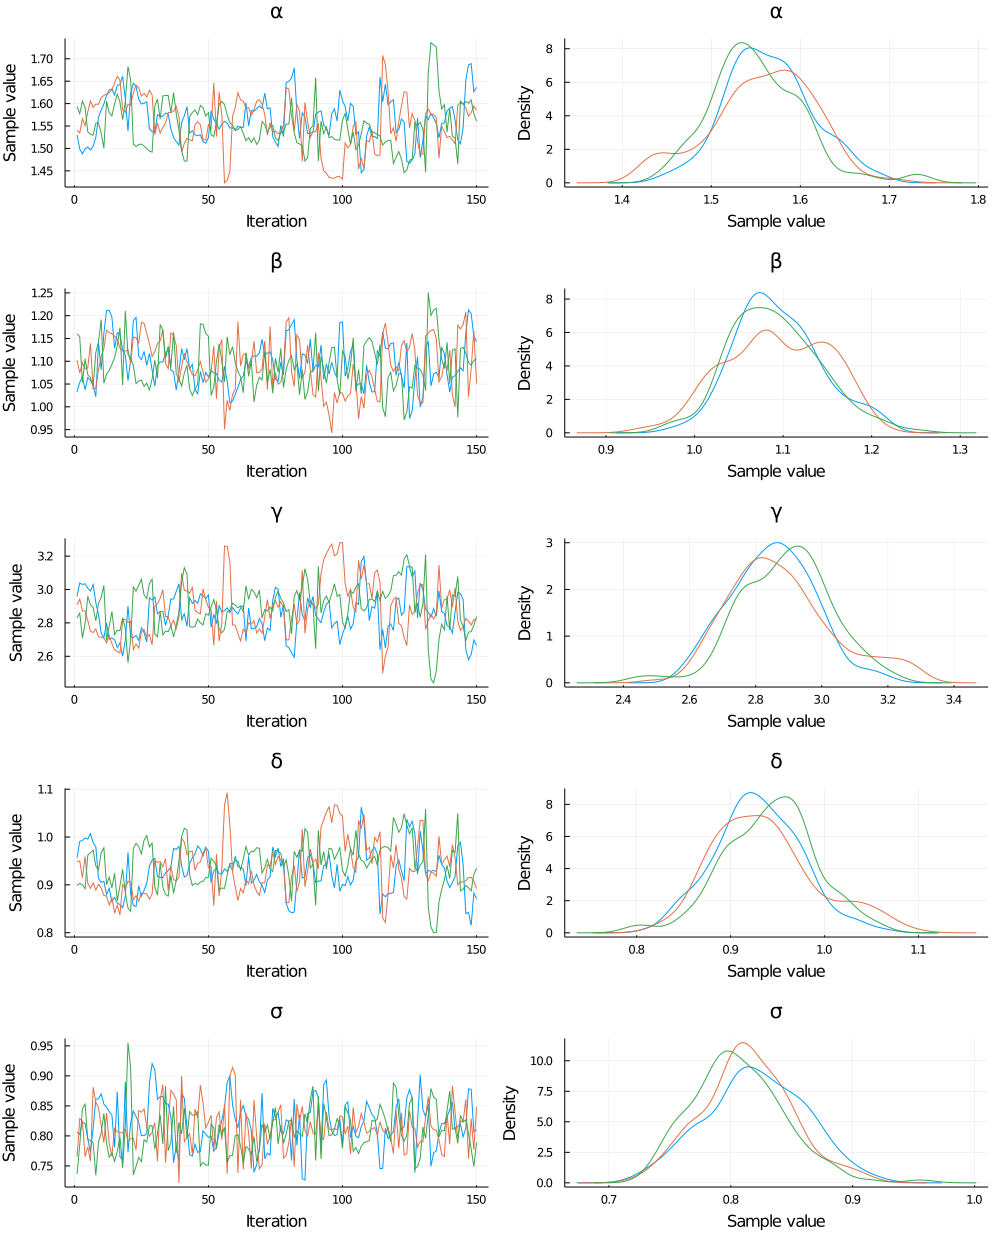

In [48]:
#chain = mapreduce(c -> sample(model, NUTS(.65),300), chainscat, 1:3)
sample(model, NUTS(.65), MCMCThreads(), 300, 3, progress=true)
plot(chain)

Finally, we select a 100 sets of parameters from the first chain and plot solutions.

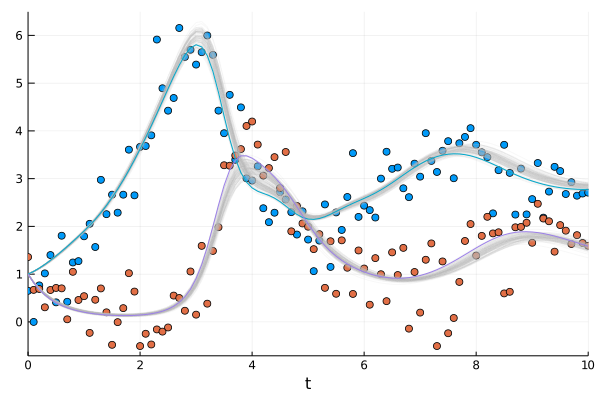

In [49]:
pl = scatter(sol.t, ddedata')
for k in sample(2:size(chain.value, 1), 100) 
    resol = solve(remake(prob1,p=chain.value[k, [:α, :β, :γ, :δ], 1].data),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
#display(pl)
plot!(sol)

Here again, the dots is the data fed to the model, the continuous colored line is the "true" solution, and the gray lines are solutions from the posterior. The fit is pretty good even though the data was quite noisy to start.

## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl). To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/). 

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite. The model sensitivities are the derivatives of the solution $u(t)$ with respect to the parameters. Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter. Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.


The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code. For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1). 

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated (and they are!), using them is dead simple. Here is a version of the Lotka-Volterra model with adjoints enabled.

All we had to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote) and boom the system takes over and we're using adjoint methods! Notice that on this model adjoints are slower. This is because adjoints have a higher overhead on small parameter models and we suggest only using these methods for models with around 100 parameters or more. For more details, see https://arxiv.org/abs/1812.01892.

In [10]:
Turing.setadbackend(:zygote)
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629


Chains MCMC chain (500×17×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           α    1.4335    0.0459     0.0021    0.0022    92.1365    1.0098  
           β    0.9345    0.0435     0.0019    0.0024   124.9325    1.0110  
           γ    3.2221    0.1521     0.0068    0.0078    97.4381    1.0122  
           δ    1.0735    0.0574     0.0026    0.0027    94.8418    1.0090  
           σ    0.8404    0.0471     0.0021    0.0040   183.6

Now we can exercise control of the sensitivity analysis method that is used by using the `sensealg` keyword argument. Let's choose the `InterpolatingAdjoint` from the available AD [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) and enable a compiled ReverseDiff vector-Jacobian product:

In [11]:
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1,sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
@time chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629


656.121711 seconds (2.40 G allocations: 133.212 GiB, 7.02% gc time)


Chains MCMC chain (500×17×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           α    1.4330    0.0413     0.0018    0.0039   111.0200    1.0109  
           β    0.9358    0.0373     0.0017    0.0030   150.8303    1.0003  
           γ    3.2230    0.1396     0.0062    0.0121   134.1149    1.0082  
           δ    1.0734    0.0505     0.0023    0.0050   108.0566    1.0126  
           σ    0.8395    0.0433     0.0019    0.0025   251.1

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/)